Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

<div style='text-align: justify;font-family:Georgia;font-size: 18px; line-height: 1.6;color:black'>
In this competitive world, every company wants to hire the best resources available on the market. Therefore, the Human Resource (HR) department plays an important role in hiring new resources for the company. As we know that there are many steps involved in finding and hiring the right candidates but the important and final one is giving an acceptable offer to candidates. After spending so much time searching and interviewing candidates, the HR team must give a competitive salary to hire them. For the HR team, determining the salary range for candidates involves so many factors like industry, location, years of experience, roles, and responsibilities. As it is a very complex process, they need a quick and reliable system that they can use for determining a competitive salary for candidates. <br>  <br> The goal of this project is to predict a competitive salary for candidates based on the industry, role, years of experience, and many attributes. This project is using python and its libraries for salary prediction.
    
</div>

In [23]:
#import your libraries
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import string
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import pylab
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV,cross_val_score,KFold,train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator,TransformerMixin
import joblib

from feature_engine.discretisers import EqualWidthDiscretiser

#your info here
__author__ = "Vijayan Nallasami"
__email__ = "VNallasami@gmail.com"

### ---- Load the data ----

In [153]:
# load files into pandas dataframe
class LoadData:
    
    def __init__(self,path,filename,target,Id,loadtype):
        
        self.file_path = path
        self.file_dict = filename
        self.target_column = target
        self.merge_Id = Id
        self.loadtype = loadtype
        
        if loadtype == 'train':        
            self.load_data()
            self.merge_df()
            self.split_train_test()
            self.find_feature_type()    
        else:
            self.load_data()
        
              
    # read csv data and load it in dataframe
    def load_data(self):
        
        for name, file in self.file_dict.items():
            
            if name == 'train_feature':
                self.train_features = pd.read_csv(self.file_path+file)
            if name == 'train_target':
                self.train_target = pd.read_csv(self.file_path+file)
            if name == 'test':
                self.test_features = pd.read_csv(self.file_path+file)
    
    # merge features and target in a single dataframe
    def merge_df(self):
        
        self.train = pd.merge(self.train_features,self.train_target,on=self.merge_Id)
        
    # find numerical and categorical features
    def find_feature_type(self):
        
        self.numerical_features   = self.train.select_dtypes(exclude='object').columns.to_list()
        self.categorical_features = self.train.select_dtypes('object').columns.to_list()    
        self.categorical_features.remove(self.merge_Id)
        
    # split dataframe as features and target
    def split_X_y(self, df, target):
        
        X = df.drop(labels=target,axis=1)
        y = df[target]
        
        return X,y
    
    def split_train_test(self):
        
        df = self.train.sample(frac=1,random_state = 0).reset_index(drop=True) 
        
        X_train, y_train = self.split_X_y(df, self.target_column)
        
        X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=998)
        X_train.shape,X_test.shape,y_train.shape,y_test.shape
        
        self.train_df = pd.concat([X_train,y_train],axis=1)
        self.test_df  = pd.concat([X_test,y_test],axis=1)

In [154]:
# config variables and display settings
PATH = 'data/'
TRAIN_FILENAMES = {'train_feature':'train_features.csv','train_target':'train_salaries.csv'}
TEST_FILENAMES = {'test':'test_features.csv'}
TARGET = 'salary'
ID = 'jobId'
MODEL_NAME = 'SalaryPredictionModel'

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
np.set_printoptions(linewidth=100)

In [155]:
# Load the data from csv file to pandas dataframe
data    = LoadData(PATH,TRAIN_FILENAMES,TARGET,ID,'train')
categorical = data.categorical_features
numerical = data.numerical_features
train = data.train_df
test = data.test_df
train.shape, test.shape

((800000, 9), (200000, 9))

### ----  Clean the data ----

In [5]:
# clean up duplicate and invalid records
class CleanUp:
    
    def __init__(self, target_name, target_min_val):
        
        self.target_min_val = target_min_val
        self.target_column  = target_name        
        
    def fit(self,df):        
        return self    
    
    def transform(self, df):
        
        self.df = df.copy()
            
        self.remove_dupes()
        self.remove_invalid_target()

        return self.df
    
    # remove duplicate records 
    def remove_dupes(self):
        
        print("Duplicate rows : ",len(self.df[self.df.duplicated(keep='first')]))
        self.df.drop_duplicates(keep='first', inplace=True)
        
    # remove the records where the target value is zero
    def remove_invalid_target(self):
        
        dupes = self.df[self.df[self.target_column] < self.target_min_val].index
        self.df.drop(dupes,inplace=True)       
        print("No.of rows with invalid target",len(dupes))

In [6]:
# remove the duplicate records and target salary < 1
cleanup = CleanUp('salary',1)
cleanup.fit(train)
train = cleanup.transform(train)

Duplicate rows :  0
No.of rows with invalid target 4


There are four records with salary zero that does not help us to predict the salary so better to remove them.

# Part 2 - Explore the data

### ----  coding ----

In [95]:
# visuvalize and explore the data
class PlotData:
    
    def __init__(self, target, numerical, categorical, out_length):
        
        self.outlier_length = out_length
        self.target = target
        self.numerical_column = numerical
        self.categorical_column = categorical
        
        print('Categorical features : ',self.categorical_column)
        print('Numerical features   : ',self.numerical_column)
        print('Training samples : {} | No.of features : {}'.format(data.train_df.shape[0],data.train_df.shape[1]))
        print('Testing  samples : {} | No.of features : {}'.format(data.test_df.shape[0],data.test_df.shape[1]))
        
    # find inter quantile range
    def iqr(self,x):
    
        return x.quantile(q=.75) - x.quantile(q=.25)
    
    # find outliers based on inter quantile range
    def outliers_count(self, x):
    
        upper_out = x.quantile(q=.75) + self.outlier_length * self.iqr(x)
        lower_out = x.quantile(q=.25) - self.outlier_length * self.iqr(x)
        
        count = len(x[x > upper_out]) + len(x[x < lower_out])

        return count
    
    # generate a summary report 
    def explore_data(self, df): 
        
        self.df = df
        
        obs = self.df.shape[0]
        types = self.df.dtypes
        counts = self.df.apply(lambda x: x.count())
        uniques = self.df.apply(lambda x: [x.unique()])
        nulls = self.df.apply(lambda x: x.isnull().sum())
        distincts = self.df.apply(lambda x: x.unique().shape[0])
        missing_ratio = (self.df.isnull().sum()/ obs) * 100
        skewness = self.df.skew()
        kurtosis = self.df.kurt() 
        outliers = self.df[self.numerical_column].apply(lambda x: self.outliers_count(x))       
        
        print(type(uniques),type(outliers))

        corr = self.df.corr()[self.target]
        self.eda = pd.concat([types, counts, distincts, nulls, missing_ratio,  skewness, kurtosis, outliers, corr], axis = 1, sort=False)
        corr_col = 'corr '  + self.target
        cols = ['Types', 'Count', 'DistinctValues', 'Nulls', 'MissingRatio',  'Skewness', 'Kurtosis', 'Outliers', corr_col ]
        self.eda.columns = cols
        
        print(self.eda)
        
        for index, value in uniques.items():
            if len(value[0]) < 20:
                print('-'*110)
                print(index, ' : ',value[0])
            else:
                print('-'*110)
                print(index,' : {} unique values'.format(len(value[0])))
        print('-'*110)    
        
    def find_skewed_boundaries(self, df, variable, distance):

        # Let's calculate the boundaries outside which sit the outliers
        # for skewed distributions

        # distance passed as an argument, gives us the option to
        # estimate 1.5 times or 3 times the IQR to calculate
        # the boundaries.

        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
        
        print("Lower boundary : {} | Upper boundary : {}".format(lower_boundary,upper_boundary))

        return lower_boundary, upper_boundary
        
    def diagnostic_plots(self, X, variable,col='green'):
        # function takes a dataframe (df) and
        # the variable of interest as arguments

        # define figure size
        plt.figure(figsize=(16, 4))

        # histogram
        plt.subplot(1, 3, 1)
        sns.distplot(X[variable], bins=30,color=col,kde_kws={'bw':0.1})
        plt.title('Histogram')

        # Q-Q plot
        plt.subplot(1, 3, 2)
        stats.probplot(X[variable].astype(float), dist="norm", plot=plt)
        plt.ylabel('Variable quantiles')

        # boxplot
        plt.subplot(1, 3, 3)
        sns.boxplot(y=X[variable].astype(float),color=col)
        plt.title('Boxplot')

        plt.show()
    
    # scatter plot list of variables
    def scatterplot(self,df,target,var_list,fig_h=12,fig_w=5):
        
        sns.set(rc={'figure.figsize':(fig_h,fig_w)})     
        for col in var_list: 
            plt.figure()
            g = sns.scatterplot(x=col, y=target, data=df)
        plt.tight_layout()
        
    # find quantiles
    def find_boundaries(self, df, variable, lw=0.05, up=0.95):

        # the boundaries are the quantiles

        lower_boundary = df[variable].quantile(lw)
        upper_boundary = df[variable].quantile(up)
        
        print("{} quantile : {} | {} quantile : {}".format(lw,lower_boundary,up,upper_boundary))

        return lower_boundary, upper_boundary
    
    # find total count of the variable and outliers
    def find_outlier_records(self,X,var,var_filt,target_filt):
        
        df_filt = X.loc[X[var] == var_filt]
        count = df_filt.shape[0]
        
        df_filt = df_filt[df_filt[self.target] > target_filt]
        
        res = df_filt.sort_values(by=self.target,ascending=False)

        print('Total count : ',count)
        print('Above IQR : ',res.shape[0])
        print('Outliers % : ',(res.shape[0]/count) * 100)

        return res
    
    # find detailed stats report
    def find_stats(self,X, var_list):
    
        print('-'*80)
        for col in var_list:   
            a = X.groupby(col)[self.target].min().to_frame()
            b = X.groupby(col)[self.target].max().to_frame()
            c = X.groupby(col)[self.target].mean().to_frame()
            d = X.groupby(col)[self.target].median().to_frame()
            e = X.groupby(col)[self.target].quantile(0.25).to_frame()
            f = X.groupby(col)[self.target].quantile(0.50).to_frame()
            g = X.groupby(col)[self.target].quantile(0.75).to_frame()
            h = X.groupby(col)[self.target].quantile(0.95).to_frame()
            i = X.groupby(col)[self.target].quantile(0.05).to_frame()
            k = X.groupby(col)[self.target].count().to_frame()
            stat = pd.concat([k,i,e,f,g,h,c,d,a,b],axis=1)
            stat.columns = ['Count','.05','.25','.50','.75','.95','Mean','Median','Min','Max']
            print(stat.astype(int).sort_values(by='Mean',ascending=True))  
            print('-'*80)
            
    # generate boxplot
    def boxplot(self, X,var_list,fig_h=12,fig_w=5):
        
        sns.set(rc={'figure.figsize':(fig_h,fig_w)})     
        for col in var_list: 
            cnt = train[col].nunique()
            plt.figure()
            ax = sns.boxplot(x=col, y=self.target, data=X)
            if cnt > 10:                
                plt.setp(ax.get_xticklabels(), rotation=90)
        plt.tight_layout()

    # generate boxplot   
    def heatmap(self, X,var_list,fig_h=12,fig_w=5):        
        
        sns.set(rc={'figure.figsize':(fig_h,fig_w)})
        df = X.copy()
        for c in var_list:
            df[c + '_group_mean'] = df[c].map(df.groupby(c)['salary'].mean().to_dict())
        ax = sns.heatmap(df.corr(), annot=True,annot_kws={'size': 20})

### ----  data visualization ----

In [173]:
eda = PlotData('salary', numerical, categorical, 1.5)

Categorical features :  ['companyId', 'jobType', 'degree', 'major', 'industry']
Numerical features   :  ['yearsExperience', 'milesFromMetropolis', 'salary']
Training samples : 750000 | No.of features : 9
Testing  samples : 250000 | No.of features : 9


The training set has eight features, one target, and 750K records, the testing set has eight features and 250K records.

In [107]:
train.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
570606,JOB1362684978293,COMP36,SENIOR,MASTERS,LITERATURE,SERVICE,14,61,113
756283,JOB1362685163970,COMP40,JUNIOR,MASTERS,BUSINESS,SERVICE,12,98,67
738227,JOB1362685145914,COMP6,MANAGER,HIGH_SCHOOL,NONE,HEALTH,12,96,79
554038,JOB1362684961725,COMP0,SENIOR,HIGH_SCHOOL,NONE,HEALTH,0,78,67
712266,JOB1362685119953,COMP7,CFO,HIGH_SCHOOL,NONE,OIL,23,41,147


In [108]:
eda.explore_data(train)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
                      Types   Count  DistinctValues  Nulls  MissingRatio  \
jobId                object  749996          749996      0           0.0   
companyId            object  749996              63      0           0.0   
jobType              object  749996               8      0           0.0   
degree               object  749996               5      0           0.0   
major                object  749996               9      0           0.0   
industry             object  749996               7      0           0.0   
yearsExperience       int64  749996              25      0           0.0   
milesFromMetropolis   int64  749996             100      0           0.0   
salary                int64  749996             277      0           0.0   

                     Skewness  Kurtosis  Outliers  corr salary  
jobId                     NaN       NaN       NaN          NaN  
companyId                 NaN       N

* Target: salary has about 5.3K outliers across the industries and jobTypes. <br>
* It seems none of the categorical variables have high cardinality. <br>
* All features are 100% populated so no imputation needed.<br>
* JobId is a unique identifier for each record so we can remove the jobId.

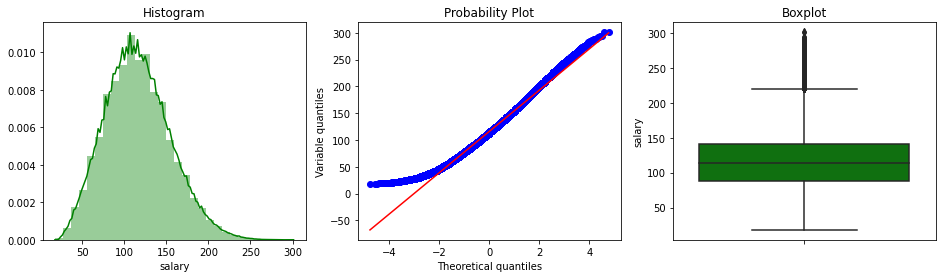

In [12]:
eda.diagnostic_plots(train,'salary')

Salary is close to normally distributed, and we can see many outliers towards the upper and lower IQR.

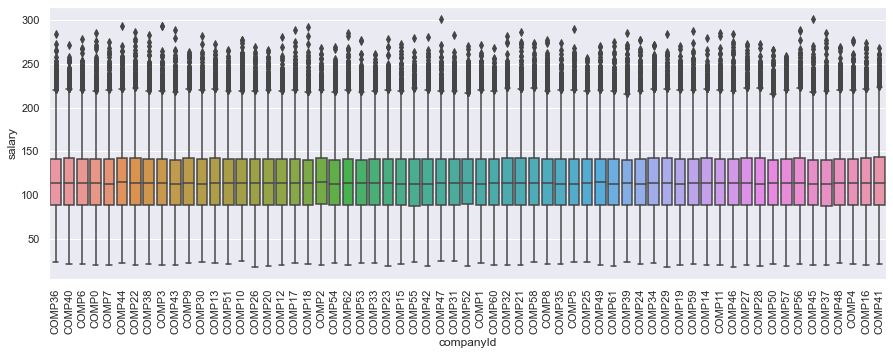

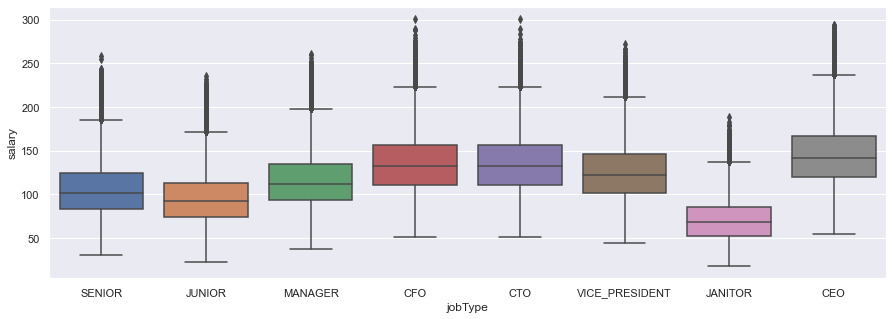

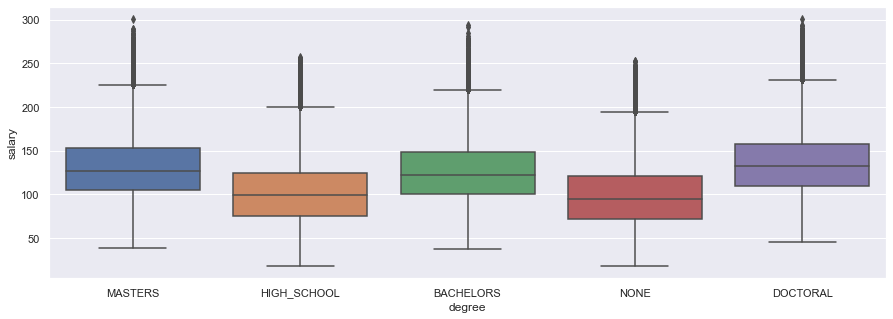

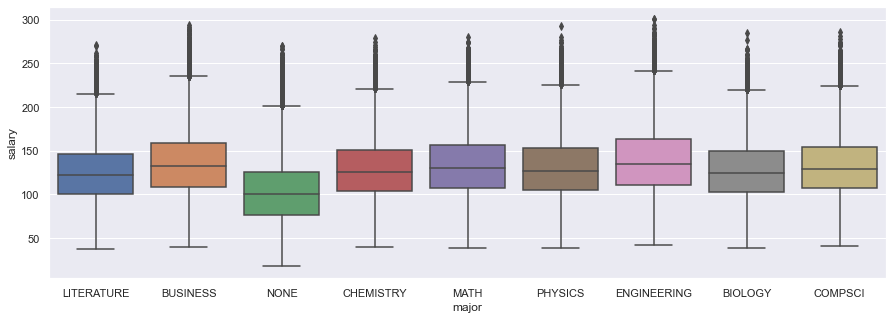

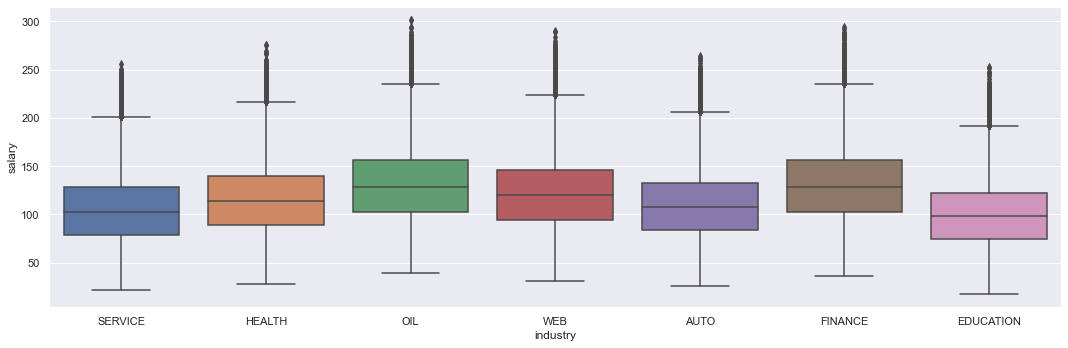

In [13]:
eda.boxplot(train,categorical,fig_h=15,fig_w=5)

* There is not much difference in salary range across companies though some companies seem to have more outliers.<br>
* Salary is varying depending upon job type, and it seems it has more predicting power to determine the salary.<br> 
* Salary is also varying based on the degree, Doctors and Engineers seem to earn a higher salary than other degree holders.<br> 
* People with no major seem to earn less than people with major. Engineering and Business major's median salary is higher than the other.<br>
* Oil and Finance industries are paying well, and the Oil and web industries have more outliers.

In [109]:
# check salary range stats across categorical features
col_list = ['jobType','degree','major','industry']
eda.find_stats(train, var_list = col_list)

--------------------------------------------------------------------------------
                Count  .05  .25  .50  .75  .95  Mean  Median  Min  Max
jobType                                                               
JANITOR         93454   36   52   68   86  116    70      68   18  189
JUNIOR          93568   53   74   92  113  149    95      92   23  236
SENIOR          94583   62   83  102  124  160   105     102   31  258
MANAGER         94230   71   93  112  135  172   115     112   37  261
VICE_PRESIDENT  93628   79  102  122  146  183   125     122   44  272
CFO             93129   87  111  132  156  195   135     132   51  301
CTO             93836   87  111  132  156  195   135     132   51  301
CEO             93568   95  120  142  167  207   145     142   55  294
--------------------------------------------------------------------------------
              Count  .05  .25  .50  .75  .95  Mean  Median  Min  Max
degree                                                     

* We can see that there is a big difference in salary across the features between 95th quantile and the maximum salary.<br>
* It seems that Mean is a little higher than the median salary across the categories of categorical variables and it is slightly skewed towards right.<br>
* Job type, Industry, and Degree have a high impact on salary.<br>
* Janitors are less earning compare to other job types.<br>
* Some CTO and CFO's are earning top salary 301 which is above CEO max salary.<br>
* Education and Service industries Mean salary is lower than in other industries.

In [15]:
# check Janitor's records who are earning double than mean salary
eda.find_outlier_records(train,var='jobType',var_filt='JANITOR',target_filt=116).head(5)

Total count :  93454
Above IQR :  4671
Outliers % :  4.998180923234961


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
676067,JOB1362685083754,COMP37,JANITOR,HIGH_SCHOOL,NONE,FINANCE,24,5,189
161699,JOB1362684569386,COMP36,JANITOR,HIGH_SCHOOL,NONE,OIL,24,9,183
937972,JOB1362685345659,COMP58,JANITOR,NONE,NONE,OIL,24,3,180
903269,JOB1362685310956,COMP11,JANITOR,HIGH_SCHOOL,NONE,FINANCE,23,2,180
613265,JOB1362685020952,COMP2,JANITOR,HIGH_SCHOOL,NONE,OIL,23,1,179


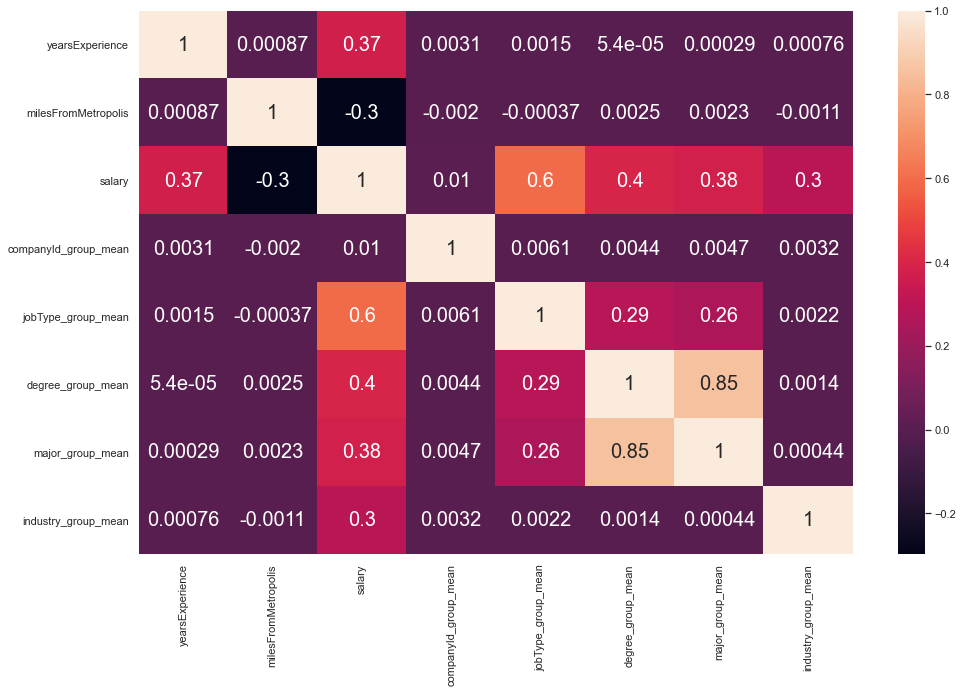

In [41]:
eda.heatmap(train,categorical,16,10)

Degree and major are co-related and companyId, milesFromMetropolis are not contributing towards salary.

# Part 3 - DEVELOP

### ---- coding ----

In [57]:
class RemoveColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, variables):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        for col in self.variables:
            if col in df:
                df.drop(labels=col, axis=1, inplace=True)
        return df        

In [136]:
class MeanEncoding(BaseEstimator, TransformerMixin):
    
    def __init__(self, target, variables):
        self.target = target
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables
    
    def fit(self, X, y):        
        df = pd.concat([X, y], axis=1)        
        self.encoding_dictionary = dict()
        for col in self.variables:
            col_mean = df.groupby([col])[self.target].mean().sort_values(ascending=True).index
            col_dict = {val: key for key, val in enumerate(col_mean,1)}            
            self.encoding_dictionary[col] = col_dict
        return self
    
    def transform(self, X):
        df = X.copy()        
        for col in self.variables:
            df[col] = df[col].map(self.encoding_dictionary[col]).astype(int)
        return df

In [132]:
class GroupMean(BaseEstimator, TransformerMixin):
    
    def __init__(self,target, variables, train_df):
        self.target = target
        self.train_df = train_df
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables
            
    def fit(self, X=None, y=None):
        self.group = self.train_df.groupby(self.variables)
        self.groupstats = pd.DataFrame({'group_mean': self.group[self.target].mean()})
        self.groupstats['group_median'] =  self.group[self.target].median()
        self.groupstats['group_min'] =  self.group[self.target].min()
        self.groupstats['group_max'] =  self.group[self.target].max()
        self.groupstats['group_std'] =  self.group[self.target].std()  
        return self
        
    def transform(self, X):        
        df = pd.merge(X,self.groupstats, on=self.variables, how='left')
        df.fillna(0, inplace=True)
        return df                   

### ---- Engineer features  ----

In [161]:
# Load the data from csv file to pandas dataframe
data    = LoadData(PATH,TRAIN_FILENAMES,TARGET,ID,'train')
categorical = data.categorical_features
numerical = data.numerical_features
train = data.train_df
test = data.test_df
train.shape, test.shape

# remove the duplicate records and target salary < 1
cleanup = CleanUp('salary',1)
cleanup.fit(train)
train = cleanup.transform(train)

Duplicate rows :  0
No.of rows with invalid target 3


In [162]:
# split model into X-features, y-target
X_train,y_train = data.split_X_y(train,'salary')

pipe = []
pipe.append(('GroupMean',GroupMean('salary', categorical, data.train)))
pipe.append(('MeanEncoding',MeanEncoding('salary', categorical)))
pipe.append(('RemoveColumns',RemoveColumns(ID)))

pipeline = Pipeline(pipe)
pipeline.fit(X_train,y_train)
X_train = pipeline.transform(X_train)

### ---- Create models ----

In [117]:
class ModelEvaluation:
    
    def __init__(self, modelname,models):
        self.modelname = modelname# split training data
        self.models = models
    
    def model_eval(self,X,y):
        # prepare configuration for cross validation test harness
        seed = 7
        # evaluate each model in turn
        mse = {}
        results = []
        names = []
        scoring = 'neg_mean_squared_error'
        print("-"*100)
        for name, model in self.models:
            kfold = KFold(n_splits=5)
            cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring,n_jobs=4)
            results.append(cv_results)
            names.append(name)        
            msg = "%s: %f (%f)" % (name + ' average MSE :', -1.0*np.mean(cv_results), cv_results.std())
            mse[model] = -1.0*np.mean(cv_results)
            print(msg)
            print("-"*100)

        self.best_model = min(mse, key=mse.get)        
        print("Best Model :",self.best_model)        
        self.train_model(self.best_model,X,y,show_feature_importance='N')
        
        return self.best_model
    
    def train_model(self,model,X,y,show_feature_importance='N'):
        
        model.fit(X,y)        
        y_pred = model.predict(X)
        self.save_model(model)
        self.check_score(y,y_pred)
        
        if show_feature_importance == 'Y': 
            self.print_feature_importance(X,model) 
    
    def make_prediction(self,input_data):
    
        _salary_prediction = joblib.load(filename=MODEL_NAME)
        results = _salary_prediction.predict(input_data)        
        return results
    
    def save_model(self,model):
        
        joblib.dump(model, MODEL_NAME)      
        
    def check_score(self, y_actual, y_pred):        
                    
        print("-"*100)
        print("Mean squared error :",metrics.mean_squared_error(y_actual, y_pred)) 
        print("r2_score :",metrics.r2_score(y_actual, y_pred))
        print("-"*100)
        
    def print_feature_importance(self,X,model):
        
        feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
        feature_importances.set_index('feature', inplace = True, drop = True)
        feature_importances.sort_values(by = 'importance', ascending = False, inplace = True)   
        feature_importances.plot.barh(figsize=(10,4))
        plt.title('Feature Importance', loc='center',weight='bold')
        plt.show() # importances

In [159]:
# prepare models
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('RandomForestRegressor', RandomForestRegressor(n_estimators = 20, random_state = 42)))
models.append(('XGBRegressor', XGBRegressor(n_estimators=500,max_depth=4,learning_rate=0.1, booster='gbtree')))
mod = ModelEvaluation("SalaryFinalModel",models)

### ---- Train models and select the best model ----

In [163]:
best_model = mod.model_eval(X_train,y_train)

----------------------------------------------------------------------------------------------------
LinearRegression average MSE :: 358.492844 (0.479451)
----------------------------------------------------------------------------------------------------
RandomForestRegressor average MSE :: 349.582394 (0.261989)
----------------------------------------------------------------------------------------------------
XGBRegressor average MSE :: 311.106152 (0.500788)
----------------------------------------------------------------------------------------------------
Best Model : XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=4,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_paralle

### ---- Test the best model with test data ----

In [164]:
# split model into X-features, y-target
X_test, y_test = data.split_X_y(test,'salary')

# Encode categorical variables, add group columns and remove Id 
X_test = pipeline.transform(X_test)

# predict the test data
y_pred = mod.make_prediction(X_test)
# find the score
mod.check_score(y_test,y_pred)

----------------------------------------------------------------------------------------------------
Mean squared error : 310.88353107426997
r2_score : 0.7925256233980218
----------------------------------------------------------------------------------------------------


# Part 4 - DEPLOY

In [171]:
data    = LoadData(PATH,TEST_FILENAMES,TARGET,ID,'test')

test_Id = data.test_features[ID]
# Encode categorical variables, add group columns and remove Id 
test = pipeline.transform(data.test_features)

final_submission = mod.make_prediction(test)

In [172]:
# save the test data result to csv file
test_salary = pd.DataFrame(final_submission,columns=['Salary'])
test_result = pd.concat([test_Id,test_salary],axis=1)
test_result.to_csv("./data/test_salaries.csv",index=False)